"In this example, we’ll show how to download, tokenize, and train a model on the IMDb reviews dataset. This task takes the text of a review and requires the model to predict whether the sentiment of the review is positive or negative. Let’s start by downloading the dataset from the Large Movie Review Dataset webpage."

    - Hugging face tutorial (https://huggingface.co/transformers/master/custom_datasets.html)

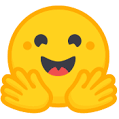

### 1. Getting the data

In [ ]:
import pandas as pd

df = pd.read_csv("../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df.head()


This data is organized into pos and neg folders with one text file per example. Let’s write a function that can read this in.

In [ ]:
def give_me_text_and_labels(input_csv="../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"):
    df = pd.read_csv(input_csv)
    
    df['label'] = [1 if x=="positive" else 0 for x in df['sentiment'] ]
    return df['review'].values, df['label'].values
    

In [ ]:
texts, labels = give_me_text_and_labels()

In [ ]:
texts[0][:100], labels[0], len(labels)

In [ ]:
train_length = 40000
train_texts, train_labels = texts[:train_length], labels[:train_length]
test_texts, test_labels = texts[train_length:], labels[train_length:]

We now have a train and test dataset, but let’s also also create a validation set which we can use for for evaluation and tuning without tainting our test set results. Sklearn has a convenient utility for creating such splits:

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

### 2. Tokenizer

Alright, we’ve read in our dataset. Now let’s tackle tokenization. We’ll eventually train a classifier using pre-trained DistilBert, so let’s use the DistilBert tokenizer.

In [ ]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Now we can simply pass our texts to the tokenizer. We’ll pass `truncation=True` and `padding=True`, which will ensure that all of our sequences are padded to the same length and are truncated to be no longer model’s maximum input length. This will allow us to feed batches of sequences into the model at the same time.

In [ ]:
type(train_texts), type(list(train_texts))

In [ ]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)

### 3. Creating a dataset object

Now, let’s turn our labels and encodings into a Dataset object. In PyTorch, this is done by subclassing a torch.utils.data.Dataset object and implementing __len__ and __getitem__. In TensorFlow, we pass our input encodings and labels to the from_tensor_slices constructor method. We put the data in this format so that the data can be easily batched such that each key in the batch encoding corresponds to a named parameter of the forward() method of the model we will train.

In [ ]:
import torch

class IMDBdataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
train_dataset = IMDBdataset(train_encodings, train_labels)
test_dataset = IMDBdataset(test_encodings,test_labels)
val_dataset = IMDBdataset(val_encodings, val_labels)


In [ ]:
# idx = 0
# # print(train_encodings.items())
# item = {key: torch.tensor(val[idx]) for key, val in train_encodings.items()}
# print(item)

Now that our datasets our ready, we can fine-tune a model either with the 🤗 Trainer/TFTrainer or with native PyTorch/TensorFlow.

### 4. Fine Tuning with native pytorch

The steps above prepared the datasets in the way that the trainer is expected. Now all we need to do is create a model to fine-tune, define the TrainingArguments/TFTrainingArguments and instantiate a Trainer/TFTrainer.

In [ ]:
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model = model.to(device=device)

In [ ]:
model.train()

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

In [ ]:
optim = AdamW(model.parameters(),lr=5e-5)

This is the all important training loop. It is giving me meory limit exceeded error! if it happens to you, comment the training loop.

In [ ]:
from tqdm import tqdm
for epoch in range(3):
    for batch in tqdm(train_dataloader):
        optim.zero_grad()
        input_ids= batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
    print(f"Loss for epoch {epoch} is {loss}")

model.eval()

once trained save it

In [ ]:
save_directory = "./"

In [ ]:
tokenizer.save_pretrained(save_directory)
model.save_pretrained(save_directory)

and loading it back

In [ ]:
# from transformers import TFAutoModel, AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained(save_directory)
# model = TFAutoModel.from_pretrained(save_directory, from_pt=True)


### 5. Building the classifier and using sequence selection

Now lets do something that is not covered in the official tutorial

In [ ]:
from transformers import pipeline
classifier =pipeline('sentiment-analysis',model=model, tokenizer=tokenizer)

In [ ]:
sample_test= test_dataset[0]
sample_test

In [ ]:
classifier("I love it")[0]

In [ ]:
test_texts[1001], test_labels[1001]

In [ ]:
classifier(test_texts[1001])[0]